In [27]:
# A notebook to run on a folder with .ncdf output. Select the plane and timesteps, and this will slice .ncdf
# Keep in mind having prop axis and cross sectional plane results help, so that one can cross check. 
# installation of xarray and netcdf4 is the best on virtualenv, so you can create venv and activate it 
#in submit script. 
#pip install xarray
#pip install netcdf4

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import constants,integrate
import xarray
au_to_micm = 0.0529177249*1e-3
au_to_voltpernm = 5.14220826e2  #1 au = 5.14220652E+11 V/m
from matplotlib.gridspec import GridSpec
c = 137  ##(au)
root_oct = './Maxwell/'
source_oct ='/ada/ptmp/mpsd/albari/everything_everywhere_allatonce/'+ \
    'the_reference_run/the_the_reference_run/emptyrun200_kbox/offset_propertime_ncdftocompare/Maxwell/'
#make use of plane result to fit the plane
filename = 'e_field-x.z=0'
try:
    e_field_oct = np.genfromtxt(root_oct+"output_iter/td.0000000/"+filename)
except IOError:
    print('Not run in the proper directory. There should be a Maxwell/output_iter directory and '+filename+' files')
    sys.exit()
npoints = int(np.sqrt(e_field_oct[:, 2].shape[0]))
xarr = np.reshape(e_field_oct[:, 0], (npoints, npoints))
yarr = np.reshape(e_field_oct[:, 1], (npoints, npoints))
xs = xarr[:, 0]
ys = yarr[0, :]
# arrange propagation axis
axis_filename = 'e_field-x.x=0,y=0'
try:
    e_field_octaxis = np.genfromtxt(root_oct+"output_iter/td.0000000/"+axis_filename)
except IOError:
    print('Not run in the proper directory. There should be a Induced/output_iter directory and '+axis_filename+' files')
    sys.exit()
proppoints = int(e_field_octaxis[:, 1].shape[0])
pos_arr_length = len(e_field_octaxis[:,0])
pos_arr = np.zeros(pos_arr_length)
pos_arr[:] = e_field_octaxis[:,0]*au_to_micm #convert to nm
tdDirs = os.listdir(root_oct+'output_iter')
tdDirs.sort()
with open('exec/parser.log', 'r') as ff:
    lines = ff.readlines()
    for line in lines:
        if 'TDTimeStep' in line:
            timestep = float(line.split()[-1])
outputinterv = int(tdDirs[1][-7:])
nframes = int(len(tdDirs))
timeitersfull = list(range(0, nframes*outputinterv, outputinterv))   # for selected timeiters : [4000,9000, 15000]
plane_index = 162  #162=mid_spiral, 200 0 plane
planes_list = pos_arr[plane_index:plane_index+1] # select the planes that are useful to you
timeiters = [0,6000,8000,11000]   #timeitersfull[:-1]  #[15000]  #timeitersfull[260:265]
efield = np.zeros((int(len(planes_list)),int(len(timeiters)), npoints, npoints))
efield_all_timesteps = np.zeros((proppoints,len(timeiters)))

ncdf_filename = 'e_field-x.ncdf'
axis_filename = 'e_field-x.x=0,y=0'

for idx, tidx in enumerate(timeiters):
    filepath = root_oct+'output_iter/td.{}/'.format(str(tidx).zfill(7))
    empty_path = source_oct+'output_iter/td.{}/'.format(str(tidx).zfill(7))
    e_field_onedim = np.genfromtxt(filepath+axis_filename)
    efield_all_timesteps[:, idx] = e_field_onedim[:,1]
    efield_data = xarray.open_dataset(root_oct +'output_iter/td.{}/'.format(str(tidx).zfill(7))+ncdf_filename 
                                      ,engine='netcdf4')
    efield_emptydata = xarray.open_dataset(source_oct +'output_iter/td.{}/'.format(str(tidx).zfill(7))+ncdf_filename 
                                      ,engine='netcdf4')
    efield_fullvolumedata = efield_data.rdata
    efield_fullvolumeemptydata = efield_emptydata.rdata
    for iplane,plane in enumerate(planes_list):
        e_field_oct_loop = efield_fullvolumedata[:,:,plane_index]
        e_field_empt_loop = 5e-5*efield_fullvolumeemptydata[:,:,plane_index]
        # We do not need reshape, it's already square data!
        efield[iplane,idx, :, :] = (e_field_oct_loop - e_field_empt_loop)*au_to_voltpernm

vmax = 5e-5 *au_to_voltpernm  #max(abs(efield.max()), abs(efield.min())) #1.0 #to fit Drude also to linear ones
axlim = au_to_micm*xs.max()  #conv to nm 
xs_micm = au_to_micm*xs
ys_micm = au_to_micm*ys
gs_kw = dict(width_ratios=[1], height_ratios=[1])
#gs_kw = dict(width_ratios=[1.5], height_ratios=[1, 4])
coef = 4054.0

offset = -12516.9279803-10*coef    #in au, far offset is this, mid one is -1.5*coef
thickness =  1.6   #micrometer
x_spiral = [(offset)*au_to_micm,offset*au_to_micm + thickness]

#if not os.path.isdir('combined_offplaneannotateplots'): os.mkdir('combined_offplaneannotateplots')
if not os.path.isdir('refarticle'): os.mkdir('refarticle')
y1lim = 5e-5*au_to_voltpernm
   # you can put planes_list and walk over selected planes here as well
    


In [28]:
planes_list

array([-2.01087355])

In [12]:
pos_arr[162]

-2.0108735462

In [13]:
with open('exec/parser.log', 'r') as ff:
    lines = ff.readlines()
    for line in lines:
        if 'TDTimeStep' in line:
            timestep = float(line.split()[-1])

In [14]:
planes_list

array([0.])

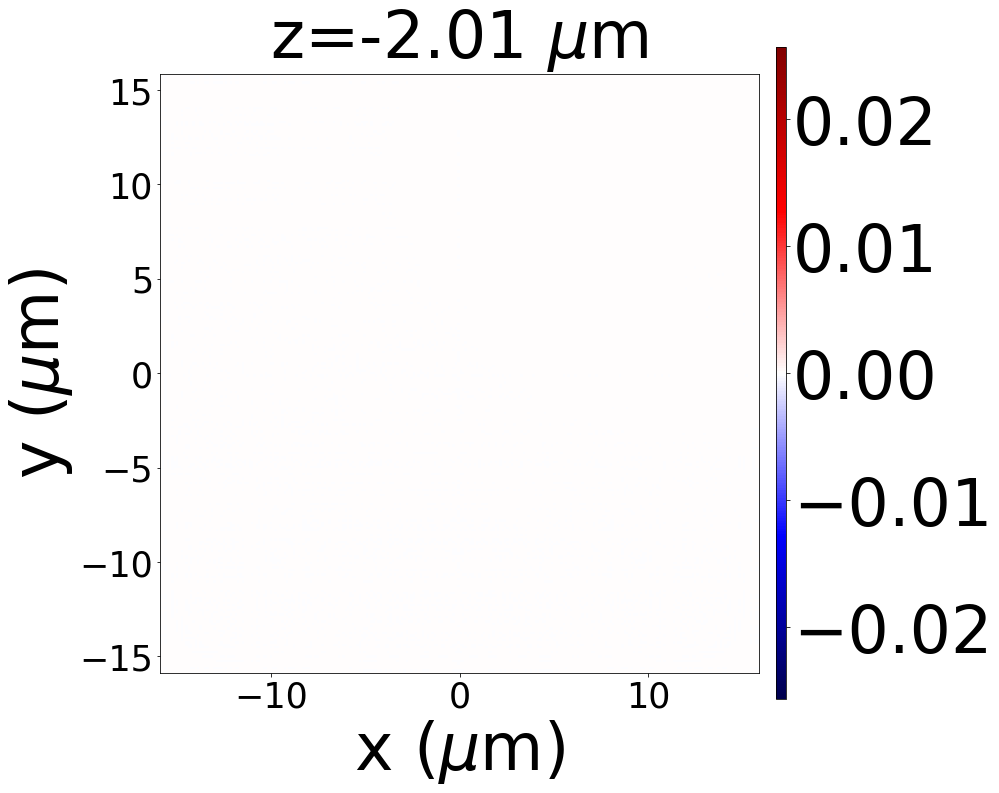

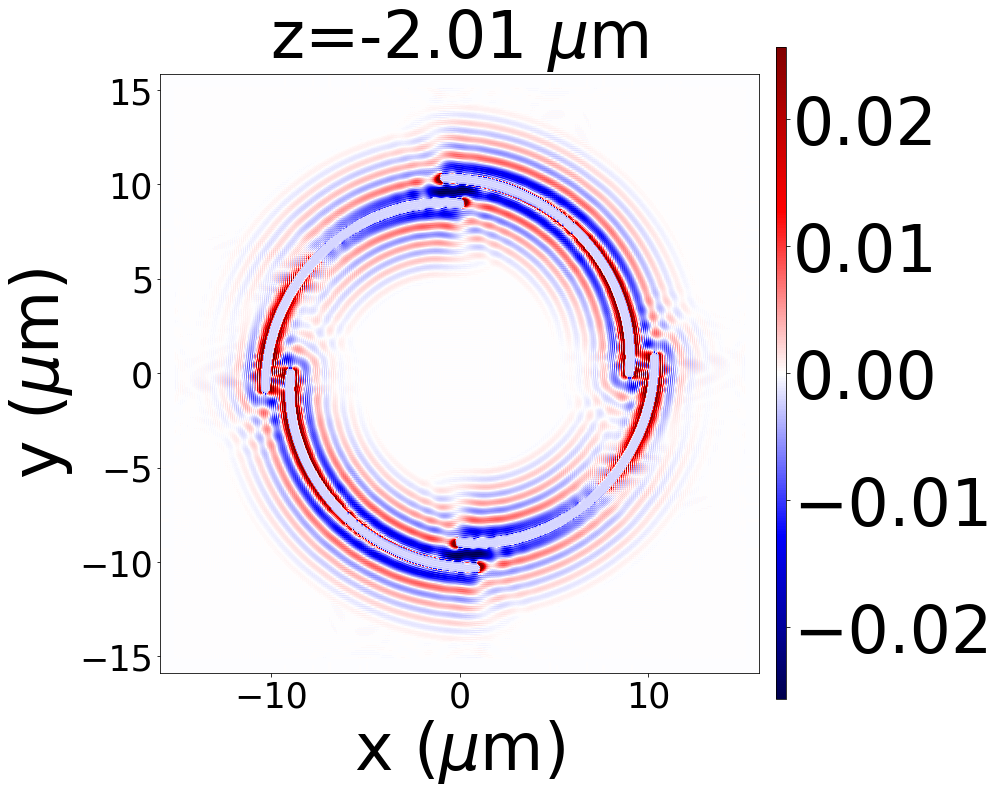

In [29]:
# alttaki hucreyi clean cizdirme denemesi
for idx, tidx in enumerate(timeiters):
    for iplane,plane in enumerate(planes_list):
        if not os.path.isdir('refarticle/allplanes_for_ts{}'.format(str(tidx).zfill(7))): \
            os.mkdir('refarticle/allplanes_for_ts{}'.format(str(tidx).zfill(7)))
        fig , axes = plt.subplots(
            nrows=1, ncols=1, sharex=False, sharey=False, 
            gridspec_kw=gs_kw ,figsize=(12.0, 12.0)
            )
        ax3 = axes.imshow(efield[iplane,idx,:,:].T, aspect = 'equal', cmap=plt.cm.seismic, \
                     extent=[xs_micm.min(), xs_micm.max(), ys_micm.max(), ys_micm.min()], vmax=vmax, vmin=-vmax)
        axes.set_xlim(-axlim, axlim)
        axes.set_ylim(-axlim, axlim)
        axes.set_title('z={} $\mu$m'.format(str(format(plane,".2f" )).zfill(5)), #str(format(plane,".2f"))
                          fontsize=65)  #iplane is plane when you do planes_list = pos_arr
#         axes.set_title('z={} $\mu$m'.format(str(format(plane,"0.0f" )).zfill(1)), #str(format(plane,".2f"))
#                   fontsize=65)  #iplane is plane when you do planes_list = pos_arr
        axes.set_xlabel('x ($\mu$m)', fontsize=65)
        axes.set_ylabel('y ($\mu$m)', fontsize=65)
        axes.tick_params(axis='both', which='major', labelsize=35)
        cbar = fig.colorbar(ax3, ax=axes, aspect=65, fraction=.08,pad=.025)
        for tt in cbar.ax.get_yticklabels():
            tt.set_fontsize(65)
        #fig.colorbar(ax3, ax=axes)
        fig.savefig('refarticle/allplanes_for_ts{}'.format(str(tidx).zfill(7))+ \
                    '/efieldx_{}_plane{}annotated_midbeam.png'.format(str(tidx).zfill(7),str(planes_list[iplane]).zfill(6)),
                    bbox_inches='tight')

In [2]:
#unit related everything 

au_to_micm = 0.0529177249*1e-3
au_to_voltpernm = 5.14220826e2  #1 au = 5.14220652E+11 V/m
au_to_m = 0.00529177249*1e-6

In [13]:
for idx, tidx in enumerate(timeiters):
    for iplane,plane in enumerate(planes_list):
        if not os.path.isdir('combined_offplaneannotateplots/allplanes_for_ts{}'.format(str(tidx).zfill(7))): \
            os.mkdir('combined_offplaneannotateplots/allplanes_for_ts{}'.format(str(tidx).zfill(7)))
        fig , axes = plt.subplots(
            nrows=2, ncols=1, sharex=False, sharey=False, 
            gridspec_kw=gs_kw ,figsize=(15.0, 15.0)
            )
        fig.suptitle("$E_{x}$ for Drude Medium \n Propagation Time : "+ format(tidx*timestep*0.02418884327,".2f") 
                     + ' fs', fontsize=25)
        for xc in x_spiral:
            axes[0].axvline(x=xc,color='r', label='Spiral')
        axes[0].plot(pos_arr,efield_all_timesteps[:,idx])
        axes[0].set_ylim(-y1lim,+y1lim)
        axes[0].axvspan(x_spiral[0], x_spiral[1], color='r', alpha=0.5)
        measurement_pos = planes_list[iplane]
        axes[0].annotate('Plane of Measurement', 
             xy=(measurement_pos,-4.5e-5), 
             xytext=(measurement_pos,-4.3e-5), 
             arrowprops = dict(arrowstyle='->', color='blue', linewidth=3, mutation_scale=50))
        #axes[0].set_xticks([-10.0,-5.0])
        axes[0].set_xlabel('z axis (nm)', fontsize=16)
        axes[0].set_ylabel('$E_{x}$ (au)', fontsize=16)
        axes[0].set_title('Emitted $E_{x}$ field through propagation axis ', fontsize=20)
        ax3 = axes[1].imshow(efield[iplane,idx,:,:].T, aspect = 'auto', cmap=plt.cm.seismic, \
                     extent=[xs_micm.min(), xs_micm.max(), ys_micm.max(), ys_micm.min()], vmax=vmax, vmin=-vmax)
        axes[1].set_xlim(-axlim, axlim)
        axes[1].set_ylim(-axlim, axlim)
        axes[1].set_title('Emitted $E_{x}$ field '+'at Z={} nm Plane'.format(str(format(plane,".2f")).zfill(5)),
                          fontsize=20)  #iplane is plane when you do planes_list = pos_arr
        axes[1].set_xlabel('x axis (nm)', fontsize=16)
        axes[1].set_ylabel('y axis (nm)', fontsize=16)
        fig.colorbar(ax3, ax=axes[1])
        fig.savefig('combined_offplaneannotateplots/allplanes_for_ts{}'.format(str(tidx).zfill(7))+ \
                    '/efieldx_{}_plane{}annotated_midbeam.png'.format(str(tidx).zfill(7),str(iplane).zfill(6)),
                    bbox_inches='tight')
        # plt.show()
        #plt.clf()  #close later
        #plt.close(fig)


ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 1080x1080 with 0 Axes>

In [7]:
for idx, tidx in enumerate(timeiters):
    for iplane,plane in enumerate(planes_list):
        if not os.path.isdir('combined_offplaneannotateplots/all_ts_for_plane{}'.format(str(plane).zfill(7))): \
            os.mkdir('combined_offplaneannotateplots/all_ts_for_plane{}'.format(str(plane).zfill(7)))
        fig , axes = plt.subplots(
            nrows=2, ncols=1, sharex=False, sharey=False, 
            gridspec_kw=gs_kw ,figsize=(15.0, 15.0)
            )
        fig.suptitle("$E_{x}$ for Drude Medium \n Propagation Time : "+ format(tidx*9.121690707944*0.01*0.02418884327,".2f") 
                     + ' fs', fontsize=25)
        for xc in x_spiral:
            axes[0].axvline(x=xc,color='r', label='Spiral')
             # plt.axvline(x=xc,color='r',label='Spiral')
        axes[0].plot(pos_arr,efield_all_timesteps[:,idx])
        axes[0].set_ylim(-y1lim,+y1lim)
        axes[0].axvspan(x_spiral[0], x_spiral[1], color='r', alpha=0.5)
        measurement_pos = planes_list[iplane]
        axes[0].annotate('Plane of Measurement', 
            xy=(measurement_pos,-1.7), 
            xytext=(measurement_pos,-2.8), 
            arrowprops = dict(arrowstyle='->', color='blue', linewidth=3, mutation_scale=50))
       # axes[0].set_xticks([-10.0,-5.0])
        axes[0].set_xlabel('z axis ($\mu$m)', fontsize=16)
        axes[0].set_ylabel('$E_{x}$ (au)', fontsize=16)
        axes[0].set_title('$E_{x}$ field through propagation axis ', fontsize=20)
        ax3 = axes[1].imshow(efield[iplane,idx,:,:].T, aspect = 'auto', cmap=plt.cm.seismic, \
                     extent=[xs_micm.min(), xs_micm.max(), ys_micm.max(), ys_micm.min()], vmax=vmax, vmin=-vmax)
        axes[1].set_xlim(-axlim, axlim)
        axes[1].set_ylim(-axlim, axlim)
        axes[1].set_title('$E_{x}$ field '+'at Z={} $\mu$m Plane'.format(str(format(plane,".2f")).zfill(5)),
                          fontsize=20)  #iplane is plane when you do planes_list = pos_arr
        axes[1].set_xlabel('x axis ($\mu$m)', fontsize=16)
        axes[1].set_ylabel('y axis ($\mu$m)', fontsize=16)
        fig.colorbar(ax3, ax=axes[1])
        fig.savefig('combined_offplaneannotateplots/all_ts_for_plane{}'.format(str(iplane).zfill(7))+ \
                    '/efieldx_{}_plane{}annotated.png'.format(str(tidx).zfill(7),str(iplane).zfill(6)),
                    bbox_inches='tight')
        # plt.show()
        #plt.clf()  #close later
        #plt.close(fig)


OSError: [Errno 36] File name too long: 'combined_offplaneannotateplots/all_ts_for_plane[-10583.54498   -10530.6272551 -10477.7095302 -10424.7918053\n -10371.8740804 -10318.9563555 -10266.0386306 -10213.1209057\n -10160.2031808 -10107.2854559 -10054.367731  -10001.4500061\n  -9948.5322812  -9895.6145563  -9842.6968314  -9789.7791065\n  -9736.8613816  -9683.9436567  -9631.0259318  -9578.1082069\n  -9525.190482   -9472.2727571  -9419.3550322  -9366.4373073\n  -9313.5195824  -9260.6018575  -9207.6841326  -9154.7664077\n  -9101.8486828  -9048.9309579  -8996.013233   -8943.0955081\n  -8890.1777832  -8837.2600583  -8784.3423334  -8731.4246085\n  -8678.5068836  -8625.5891587  -8572.6714338  -8519.7537089\n  -8466.835984   -8413.9182591  -8361.0005342  -8308.0828093\n  -8255.1650844  -8202.2473595  -8149.3296346  -8096.4119097\n  -8043.4941848  -7990.5764599  -7937.658735   -7884.7410101\n  -7831.8232852  -7778.9055603  -7725.9878354  -7673.0701105\n  -7620.1523856  -7567.2346607  -7514.3169358  -7461.3992109\n  -7408.481486   -7355.5637611  -7302.6460362  -7249.7283113\n  -7196.8105864  -7143.8928615  -7090.9751366  -7038.0574117\n  -6985.1396868  -6932.2219619  -6879.304237   -6826.3865121\n  -6773.4687872  -6720.5510623  -6667.6333374  -6614.7156125\n  -6561.7978876  -6508.8801627  -6455.9624378  -6403.0447129\n  -6350.126988   -6297.2092631  -6244.2915382  -6191.3738133\n  -6138.4560884  -6085.5383635  -6032.6206386  -5979.7029137\n  -5926.7851888  -5873.8674639  -5820.949739   -5768.0320141\n  -5715.1142892  -5662.1965643  -5609.2788394  -5556.3611145\n  -5503.4433896  -5450.5256647  -5397.6079398  -5344.6902149\n  -5291.77249    -5238.8547651  -5185.9370402  -5133.0193153\n  -5080.1015904  -5027.1838655  -4974.2661406  -4921.3484157\n  -4868.4306908  -4815.5129659  -4762.595241   -4709.6775161\n  -4656.7597912  -4603.8420663  -4550.9243414  -4498.0066165\n  -4445.0888916  -4392.1711667  -4339.2534418  -4286.3357169\n  -4233.417992   -4180.5002671  -4127.5825422  -4074.6648173\n  -4021.7470924  -3968.8293675  -3915.9116426  -3862.9939177\n  -3810.0761928  -3757.1584679  -3704.240743   -3651.3230181\n  -3598.4052932  -3545.4875683  -3492.5698434  -3439.6521185\n  -3386.7343936  -3333.8166687  -3280.8989438  -3227.9812189\n  -3175.063494   -3122.1457691  -3069.2280442  -3016.3103193\n  -2963.3925944  -2910.4748695  -2857.5571446  -2804.6394197\n  -2751.7216948  -2698.8039699  -2645.886245   -2592.9685201\n  -2540.0507952  -2487.1330703  -2434.2153454  -2381.2976205\n  -2328.3798956  -2275.4621707  -2222.5444458  -2169.6267209\n  -2116.708996   -2063.7912711  -2010.8735462  -1957.9558213\n  -1905.0380964  -1852.1203715  -1799.2026466  -1746.2849217\n  -1693.3671968  -1640.4494719  -1587.531747   -1534.6140221\n  -1481.6962972  -1428.7785723  -1375.8608474  -1322.9431225\n  -1270.0253976  -1217.1076727  -1164.1899478  -1111.2722229\n  -1058.354498   -1005.4367731   -952.5190482   -899.6013233\n   -846.6835984   -793.7658735   -740.8481486   -687.9304237\n   -635.0126988   -582.0949739   -529.177249    -476.2595241\n   -423.3417992   -370.4240743   -317.5063494   -264.5886245\n   -211.6708996   -158.7531747   -105.8354498    -52.9177249\n      0.            52.9177249    105.8354498    158.7531747\n    211.6708996    264.5886245    317.5063494    370.4240743\n    423.3417992    476.2595241    529.177249     582.0949739\n    635.0126988    687.9304237    740.8481486    793.7658735\n    846.6835984    899.6013233    952.5190482   1005.4367731\n   1058.354498    1111.2722229   1164.1899478   1217.1076727\n   1270.0253976   1322.9431225   1375.8608474   1428.7785723\n   1481.6962972   1534.6140221   1587.531747    1640.4494719\n   1693.3671968   1746.2849217   1799.2026466   1852.1203715\n   1905.0380964   1957.9558213   2010.8735462   2063.7912711\n   2116.708996    2169.6267209   2222.5444458   2275.4621707\n   2328.3798956   2381.2976205   2434.2153454   2487.1330703\n   2540.0507952   2592.9685201   2645.886245    2698.8039699\n   2751.7216948   2804.6394197   2857.5571446   2910.4748695\n   2963.3925944   3016.3103193   3069.2280442   3122.1457691\n   3175.063494    3227.9812189   3280.8989438   3333.8166687\n   3386.7343936   3439.6521185   3492.5698434   3545.4875683\n   3598.4052932   3651.3230181   3704.240743    3757.1584679\n   3810.0761928   3862.9939177   3915.9116426   3968.8293675\n   4021.7470924   4074.6648173   4127.5825422   4180.5002671\n   4233.417992    4286.3357169   4339.2534418   4392.1711667\n   4445.0888916   4498.0066165   4550.9243414   4603.8420663\n   4656.7597912   4709.6775161   4762.595241    4815.5129659\n   4868.4306908   4921.3484157   4974.2661406   5027.1838655\n   5080.1015904   5133.0193153   5185.9370402   5238.8547651\n   5291.77249     5344.6902149   5397.6079398   5450.5256647\n   5503.4433896   5556.3611145   5609.2788394   5662.1965643\n   5715.1142892   5768.0320141   5820.949739    5873.8674639\n   5926.7851888   5979.7029137   6032.6206386   6085.5383635\n   6138.4560884   6191.3738133   6244.2915382   6297.2092631\n   6350.126988    6403.0447129   6455.9624378   6508.8801627\n   6561.7978876   6614.7156125   6667.6333374   6720.5510623\n   6773.4687872   6826.3865121   6879.304237    6932.2219619\n   6985.1396868   7038.0574117   7090.9751366   7143.8928615\n   7196.8105864   7249.7283113   7302.6460362   7355.5637611\n   7408.481486    7461.3992109   7514.3169358   7567.2346607\n   7620.1523856   7673.0701105   7725.9878354   7778.9055603\n   7831.8232852   7884.7410101   7937.658735    7990.5764599\n   8043.4941848   8096.4119097   8149.3296346   8202.2473595\n   8255.1650844   8308.0828093   8361.0005342   8413.9182591\n   8466.835984    8519.7537089   8572.6714338   8625.5891587\n   8678.5068836   8731.4246085   8784.3423334   8837.2600583\n   8890.1777832   8943.0955081   8996.013233    9048.9309579\n   9101.8486828   9154.7664077   9207.6841326   9260.6018575\n   9313.5195824   9366.4373073   9419.3550322   9472.2727571\n   9525.190482    9578.1082069   9631.0259318   9683.9436567\n   9736.8613816   9789.7791065   9842.6968314   9895.6145563\n   9948.5322812  10001.4500061  10054.367731   10107.2854559\n  10160.2031808  10213.1209057  10266.0386306  10318.9563555\n  10371.8740804  10424.7918053  10477.7095302  10530.6272551\n  10583.54498  ]'

In [14]:
len(planes_list)

1